In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import mne

In [5]:
import os

In [6]:
import keras

Using TensorFlow backend.


In [7]:
import seaborn as sns

In [8]:
from collections import Counter

In [9]:
from tqdm import tqdm_notebook
from tqdm import tqdm_notebook as tqdm

In [10]:
import matplotlib.pyplot as plt

Какие каналы содержат 

Dataset:
- Один сэмпл содержит чанк сигнала, чанки не пересекаются
- Считывание происходит из случайных файлов из списка
- Чанки рандомизированы:
    - Учесть рандомизацию по номеру пациента, сессии, времени

# Read labels

In [11]:
header = ["file", "start", "end", "label", "confidence"]
train_df = pd.read_csv("../_DOCS/ref_train.txt", sep=" ", names=header)
val_df = pd.read_csv("../_DOCS/ref_dev.txt", sep=" ", names=header)

In [12]:
def preprocess_file(full_file):
    parts = full_file.split("_")
    patient = int(parts[0])
    session = int(parts[1][1:])
    file = int(parts[2][1:])
    return [patient, session, file]

In [13]:
preprocess_file("00000258_s002_t000")

[258, 2, 0]

In [14]:
def append_file_info(df):
    values = np.array(df["file"].apply(preprocess_file).tolist())
    files_df = pd.DataFrame(values, columns=["patient", "session", "chunk"], index=df.index)
    return df.merge(files_df, how="inner", left_index=True, right_index=True)

In [15]:
train_df = append_file_info(train_df)

In [16]:
val_df = append_file_info(val_df)

# Attach files

TODO add other electrode formats

In [17]:
def attach_files(df, dataset):
    paths = {}

    for root, dirs, files in os.walk("../edf/{}".format(dataset)):
        path = root.split(os.sep)
        for file in files:
            if ".edf" in file:
                name = file.split(".")[0]
                paths[name] = os.path.abspath(root) + "/" +  file
    
    df["full_path"] = df["file"].apply(paths.get)
    df = df[df["full_path"].apply(lambda x: "01_tcp_ar" in str(x))].copy()
    return df

In [18]:
train_df = attach_files(train_df, "train")

In [19]:
val_df = attach_files(val_df, "dev")

# Separate patients

In [20]:
train_patients = train_df["patient"].unique() 

In [21]:
val_patients = val_df["patient"].unique()

In [22]:
val_df = val_df[~val_df["patient"].isin(train_patients)].copy()

# Remove bckg files

In [23]:
def remove_bckg_files(df):
    files_with_seizures = df[df["label"] == "seiz"]["file"].unique()
    return df[df["file"].isin(files_with_seizures)].copy()

In [24]:
train_df = remove_bckg_files(train_df)

In [25]:
val_df = remove_bckg_files(val_df)

# Calculate channels intersection and proper sample rate

In [26]:
def get_edf_info(df):
    files = df["full_path"].unique()

    edf_data = []

    for file in tqdm_notebook(files):
        edf = mne.io.read_raw_edf(file, verbose="ERROR")
        data = {
            field: edf.info[field]
            for field in ["ch_names", "sfreq"]
        }
        edf_data.append(data)
        
    return pd.DataFrame(edf_data)

In [27]:
train_edf_df = get_edf_info(train_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [28]:
val_edf_df = get_edf_info(val_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [29]:
CHUNK_FREQUENCY = int(min(train_edf_df["sfreq"].min(), val_edf_df["sfreq"].min()))

In [30]:
counter = Counter([
    channel for channels_list in train_edf_df["ch_names"] for channel in channels_list
] + [
    channel for channels_list in val_edf_df["ch_names"] for channel in channels_list
])

In [31]:
all_channels = dict(counter.most_common())

In [32]:
usage_limit = max([v for k, v in all_channels.items() if "STI" not in k])
CHANNELS = [k for k, v in all_channels.items() if v >= usage_limit and "STI" not in k]

In [33]:
# STIM_CHANNEL = [k for k in all_channels.keys() if "STI" in k][0]

In [34]:
len(CHANNELS)

21

# Calculate chunk size

In [35]:
train_df["duration"] = train_df["end"] - train_df["start"]

label
bckg    AxesSubplot(0.125,0.125;0.775x0.755)
seiz    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration, dtype: object

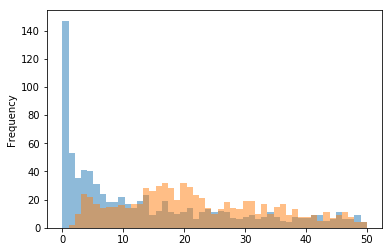

In [36]:
train_df.groupby('label')["duration"].plot(kind="hist", bins=np.linspace(0, 50), alpha=0.5)

In [37]:
CHUNK_TIME = 1 * CHUNK_FREQUENCY # number of terms per chunk

# Split on chunks

In [38]:
BATCH_SIZE = 32

- Get all file names, randomize them
- For each file - split on chunks, randomize them
- Get labels for each chunk

In [39]:
FFT_STEPS_NUM = 125

TODO:
- Fourier transform for chunk instead of full file

Как западить чанку нулями, и убрать их из лосса? Варианты:

### Удалять пустые чанки
3. Заменить в массиве data и events неполные чанки на зануленные
4. Добавить параметр mask, который отвечает за то, какие элементы функции потерь оставить
5. Заменить лосс


In [40]:
MAX_LENGTH = 300000

In [41]:
def get_fourier_transform(data, window_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM):
    frequencies = []
    for window in range(0, data.shape[0] - window_size, step_size):
        chunk = data[window:window + window_size]
        frequency_values = np.abs(np.fft.fft(chunk, axis=0))[:window_size // 2]
        frequencies.append(frequency_values)
    result = np.stack(frequencies)
    return result

In [42]:
def get_data(df, file, channels=CHANNELS, chunk_size=CHUNK_TIME):
    annotations = df[
        (df["full_path"] == file) & \
        (df["label"] == "seiz")
    ][["start", "end"]]
    edf = mne.io.read_raw_edf(file, preload=True, verbose='ERROR')
    edf.filter(2, 60)
    edf_picks = edf.pick_channels(channels)
    data, time = edf_picks[:]
        
    events = time * 0
    for _, (start, end) in annotations.iterrows():
        events += (time >= start) & (time <= end)
    events = (events > 0).astype(int)
    
    del edf
    
    return data, events

In [43]:
def get_data_multiple(df, files, channels=CHANNELS, chunk_size=CHUNK_TIME):
    total_data = []
    total_events = []
    for file in tqdm_notebook(files):
        data, events = get_data(df, file)
        total_data.append(data)
        total_events.append(events)
    
    return total_data, total_events

In [44]:
class ChunksIterator():
    def __init__(self, data, events, chunk_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM, max_length=MAX_LENGTH, tqdm_enabled=False):
        self.data = data
        self.events = events
        self.chunk_size = chunk_size
        self.step_size = step_size
        self.valid_chunks = 0
        
        max_time = min(max([e.shape[0] for e in events]), max_length)
        self.iterations = range(0, max_time - 2*chunk_size, chunk_size)
        self.iterations_number = len(self.iterations)
        if tqdm_enabled:
            self.iterations = tqdm(self.iterations)
        self.iterations = iter(self.iterations)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        data = self.data
        events = self.events
        chunk_size = self.chunk_size
        step_size = self.step_size
        chunk_start = next(self.iterations)
        
        data_chunk = [d[:, chunk_start:chunk_start + 2*chunk_size].T for d in data]
        labels_chunk = [e[chunk_start:chunk_start + chunk_size] for e in events]

        zero_data_chunk = np.zeros((chunk_size * 2, len(CHANNELS)))
        zero_labels_chunk = np.zeros((chunk_size, ))

        masks_chunk = [e.shape[0] == chunk_size for e in labels_chunk]
        data_chunk = [d if d.shape[0] == 2*chunk_size else zero_data_chunk for d in data_chunk]
        labels_chunk = [e if e.shape[0] == chunk_size else zero_labels_chunk for e in labels_chunk]

        data_chunk = [get_fourier_transform(d) for d in data_chunk]
        labels_chunk = [e.reshape(step_size, -1).sum(axis=0) > 0 for e in labels_chunk]
        
        self.valid_chunks += sum(masks_chunk)

        return np.stack(data_chunk), np.stack(labels_chunk)[:, :, np.newaxis], np.array(masks_chunk)

In [45]:
def iterate_files(df, batch_size=BATCH_SIZE):
    files = df["full_path"].unique()
    files = np.random.choice(files, len(files), replace=False)
    for files in zip(*[iter(files)]*batch_size):
        yield files

In [46]:
files = next(iterate_files(train_df))

In [47]:
data, events = get_data(train_df, files[0])

In [48]:
files = train_df["full_path"].value_counts().index[0:BATCH_SIZE]
data, events = get_data_multiple(train_df, files)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [49]:
partial_lengths = [int(d.shape[1] * 0.005) for d in data]
partial_data = [d[:, :l] for d, l in zip(data, partial_lengths)]
partial_events = [e[:l] for e, l in zip(events, partial_lengths)]
min(partial_lengths)

384

In [50]:
iterator = ChunksIterator(partial_data, partial_events, tqdm_enabled=True)

print("Total iterations:", iterator.iterations_number)

for i, (data_chunk, labels_chunk, masks_chunk) in zip(range(10), iterator):
    print("Iteration {}".format(i), sum(masks_chunk))
    
print("Valid chunks:", iterator.valid_chunks)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


Total iterations: 48
Iteration 0 32
Iteration 1 29
Iteration 2 28
Iteration 3 19
Iteration 4 17
Iteration 5 17
Iteration 6 11
Iteration 7 9
Iteration 8 6
Iteration 9 5
Valid chunks: 173


In [51]:
data_chunk.shape

(32, 125, 125, 21)

# Model creation

In [49]:
RNN_SIZE = 128
NUM_EPOCHS = 10

In [50]:
CNN_FILTERS = (32, 64, 128, 256)

In [51]:
HIDDEN_DIMS = (1024, 1024)

Можно ли добавить CNN?
- Conv1D: (BATCH_SIZE, CHUNK_TIME, CHANNELS) -> (BATCH_SIZE, CHUNK_TIME, CNN_FILTERS)
- MaxPool1D: (BATCH_SIZE, CHUNK_TIME, CNN_FILTERS) -> (BATCH_SIZE, CHUNK_TIME // POOL_SIZE, CNN_FILTERS)

Продолжать до тех пор, пока чанка не станет достаточного размера

In [52]:
import tensorflow as tf
from keras.layers import Dense,Activation,Dropout, Input, Conv1D, MaxPool1D, Flatten
from keras.layers import LSTM,Bidirectional,TimeDistributed #could try TimeDistributed(Dense(...))
from keras.models import Sequential, load_model
from keras import optimizers,regularizers
from keras.layers.normalization import BatchNormalization
import keras.backend.tensorflow_backend as KTF

In [53]:
eeg_input = Input(batch_shape=(BATCH_SIZE, FFT_STEPS_NUM, CHUNK_TIME // 2, len(CHANNELS)))

feature_extractor = eeg_input

for cnn_filters in CNN_FILTERS:
    feature_extractor = TimeDistributed(Conv1D(cnn_filters, kernel_size=7, padding="same", activation="relu"))(feature_extractor)
#     feature_extractor = TimeDistributed(Conv1D(cnn_filters, kernel_size=5, padding="same", activation="relu"))(feature_extractor)
#     feature_extractor = TimeDistributed(Conv1D(cnn_filters, kernel_size=3, padding="same", activation="relu"))(feature_extractor)
    feature_extractor = TimeDistributed(MaxPool1D(pool_size=2, padding="same"))(feature_extractor)

rnn = TimeDistributed(Flatten())(feature_extractor)
rnn = Bidirectional(LSTM(RNN_SIZE, return_sequences=True, stateful=True))(rnn)

x = Dropout(0.2)(rnn)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
events_output = Dense(1, activation='sigmoid')(x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [54]:
model = keras.models.Model(inputs=[eeg_input], outputs=[events_output])

In [55]:
s = tf.Session()

In [56]:
# a = data_chunk
# b = data_chunk
# c = [0] * 10 + [1] * 22
# binary_crossentropy_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=a, logits=b)
# masked_binary_crossentropy_loss = tf.boolean_mask(binary_crossentropy_loss, c, axis=0)
# s.run(masked_binary_crossentropy_loss).shape

In [57]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [58]:
# def masked_binary_crossentropy(y_true, y_pred):
#     global squeezed_masks_input
#     binary_crossentropy_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
#     masked_binary_crossentropy_loss = tf.boolean_mask(binary_crossentropy_loss, squeezed_masks_input, axis=0)
#     return tf.reduce_mean(binary_crossentropy_loss)

In [59]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [60]:
model.compile(
    loss="binary_crossentropy",
#     loss=focal_loss(),
    optimizer='adam', 
    metrics=['accuracy', recall_m, precision_m]
)

# TODO Try to filter incomplete chunks

# Overfit on small dataset

TODO make model converge on this batch

In [63]:
# generator = ChunksIterator(data, events)

In [64]:
# for i in range(5):
#     next(generator)
# x_in, y_end, masks_in = next(generator)

In [66]:
y_end.sum() / (y_end > -1).sum()

0.46875

In [67]:
# s.run(tf.global_variables_initializer())

In [68]:
# # total_loss = masked_binary_crossentropy(model.outputs[0], tf.cast(y_end, dtype=tf.float32))
# y_true = tf.cast(y_end, dtype=tf.float32)
# y_pred = model.outputs[0]
# total_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
# total_loss = tf.reduce_mean(tf.reduce_mean(tf.squeeze(total_loss), axis=1), axis=0)
# # total_loss = keras.losses.binary_crossentropy(y_true, y_pred)

In [69]:
# total_loss_values = s.run(total_loss, {
#     model.inputs[0]: x_in,
#     model.inputs[1]: masks_in[:, np.newaxis],
# })

In [70]:
model.predict(x_in).mean()

0.5

In [71]:
model.evaluate(x_in, y_end)

32/32 [==============================] - 1s 39ms/step


[0.6931472420692444,
 0.5795000195503235,
 0.29546666145324707,
 0.6054644584655762]

In [72]:
# model.fit(x_in, y_end, batch_size=x.shape[0], epochs=1000, sample_weight=masks_in)

In [73]:
y_end.sum()

1875

RNN использовать можно и даже немного нужно
А вот seq2seq не надо - у вас же одинаковая длина входа и выхода. Имплементация будет очень похожа не языковую модельку, как была в последней домашке.

Если это исследования, а не в прод катить, я бы попробовал LMU и LSTM-SHA из реккурентных и Sparse Transformer

# Train model

In [65]:
GENERATOR_PAD_BUG = 1

In [ ]:
total_train_history = {}
total_val_history = {}

for epoch in tqdm(range(10)):
    total_train_history[epoch] = []
    total_val_history[epoch] = []
    
    total_train_loss = 0
    total_train_chunks = 0
    
    total_val_loss = 0
    total_val_chunks = 0
    
    for train_files, val_files in tqdm_notebook(list(zip(iterate_files(train_df), iterate_files(val_df)))):
        # Training
        
        train_data, train_events = get_data_multiple(train_df, train_files)
        train_generator = ChunksIterator(train_data, train_events, tqdm_enabled=True)
        
        train_chunks = train_generator.iterations_number
        
        train_history = model.fit_generator(
            train_generator, 
            epochs=1, 
            steps_per_epoch=train_chunks - GENERATOR_PAD_BUG,
#             pickle_safe=False
        )
        
        total_train_loss += train_history.history['loss'][0] * train_generator.valid_chunks
        total_train_chunks += train_generator.valid_chunks
        
        model.reset_states()
        
        del train_generator
        del train_data
        del train_events
        
        # Validation
        
        val_data, val_events = get_data_multiple(val_df, val_files)
        val_generator = ChunksIterator(val_data, val_events, tqdm_enabled=True)
        
        val_chunks = val_generator.iterations_number
        
        val_metrics = model.evaluate_generator(
            val_generator,
            steps=val_chunks - GENERATOR_PAD_BUG,
#             pickle_safe=False
        )
        
        print(val_metrics)
        
        total_val_loss += val_metrics[0] * val_generator.valid_chunks
        total_val_chunks += val_generator.valid_chunks
        
        model.reset_states()
        del val_generator
        del val_data
        del val_events
        
        total_train_history[epoch].append(total_train_loss / total_train_chunks)
        total_val_history[epoch].append(total_val_loss / total_val_chunks)
        
        print("Train loss:", total_train_history)
        print("Val loss:", total_val_history)
    
    model.save_weights("./models/cnn-lstm-fft-model-{}.h5".format(epoch))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1197/1197 [==============================] - 1422s 1s/step - loss: 0.3858 - acc: 0.8865 - recall_m: 0.4122 - precision_m: 0.4794


[1.4173409880552077, 0.8186614450655485, 0.03755560933410773, 0.291270753544574]

Train loss: {0: [0.3857671076007057]}
Val loss: {0: [1.4173409880552077]}


Epoch 1/1
1197/1197 [==============================] - 1433s 1s/step - loss: 0.4343 - acc: 0.8006 - recall_m: 0.2759 - precision_m: 0.3382


[0.6742298536083553, 0.8357516707433893, 0.0, 0.0]

Train loss: {0: [0.3857671076007057, 0.4073591660177006]}
Val loss: {0: [1.4173409880552077, 1.017560870719612]}


Epoch 1/1
1197/1197 [==============================] - 1394s 1s/step - loss: 0.5542 - acc: 0.8973 - recall_m: 0.8505 - precision_m: 0.5874


[9.00976618628952, 0.17623705090449168, 0.982318447397068, 0.15158325497842173]

Train loss: {0: [0.3857671076007057, 0.4073591660177006, 0.44985267802523227]}
Val loss: {0: [1.4173409880552077, 1.017560870719612, 3.4544201796780984]}


Epoch 1/1
1197/1197 [==============================] - 1395s 1s/step - loss: 0.2170 - acc: 0.8588 - recall_m: 0.8005 - precision_m: 0.5168


[2.972684629778117, 0.6354801566927455, 0.32649651761092835, 0.27397567686082525]

Train loss: {0: [0.3857671076007057, 0.4073591660177006, 0.44985267802523227, 0.3887520367155386]}
Val loss: {0: [1.4173409880552077, 1.017560870719612, 3.4544201796780984, 3.3203803783641543]}


Epoch 1/1
1197/1197 [==============================] - 1592s 1s/step - loss: 0.2684 - acc: 0.8880 - recall_m: 0.5221 - precision_m: 0.4275



[1.2854813364713313, 0.4894269005945551, 0.20642139479430796, 0.09744568028446028]
Train loss: {0: [0.3857671076007057, 0.4073591660177006, 0.44985267802523227, 0.3887520367155386, 0.3659758377221611]}
Val loss: {0: [1.4173409880552077, 1.017560870719612, 3.4544201796780984, 3.3203803783641543, 2.962052297725313]}


Epoch 1/1
1197/1197 [==============================] - 1790s 1s/step - loss: 0.2010 - acc: 0.9274 - recall_m: 0.7902 - precision_m: 0.7648


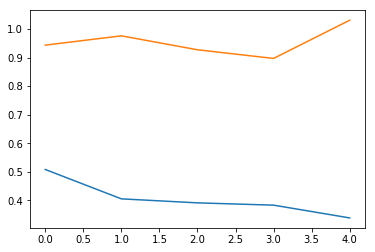

In [111]:
plt.plot([train_losses[k][-1] for k in range(5)])
plt.plot([val_losses[k][-1] for k in range(5)])

In [78]:
model.load_weights("./models/cnn-lstm-fft-model-9.h5")

# Проверено
- Участки с нулевым precision/recall - почему val и train одинаково содержат/не содержат нули? - удалены временно
- Влияет ли присутствие одинаковых пациентов/сессий в train/test? - разбиты на группы
- Файлы во всю длину, не учитывать loss - готово
- Собирать чанки tN файлов в один файл - не нужно пока что

# Проверить
- Модель переобучается, как можно ее уменьшить?
- Переименовывать каналы других интерфейсов - проверить различные интерфейсы на предмет соответствия каналов
- Влияние масштабирования сигнала 
- Можно ли использовать чанку большего размера? Можно ли ее предварительно сжать с помощью CNN? Как это повлияет на предсказание? Какие еще преобразования сигнала можно использовать?
- Применима ли к данным фильтрация? моргания-движения/?
- Расстояние между приступами - не менее 3с, можно ли это использовать для сглаживания сегментов?
- Какой бэйслайн имеет случайное предсказание? Мне кажется, он достаточно высокий
- Как сравнять веса классов?
- Минимальный размер чанки FFT?

# Архитектура с использованием сверток
1. Вход - FFT_STEPS x FREQUENCIES x CHANNELS
2. Свертка последовательности:
    - 1D свертка по каналам FFT_STEPS x FREQUENCIES x CHANNELS -(k=3,s=1)> FFT_STEPS x FREQUENCIES x CNN_FILTERS_1
    - 1D макс пулинг FFT_STEPS x FREQUENCIES x CNN_FILTERS_1 -(s=2)> FFT_STEPS x FREQUENCIES / 2 x CNN_FILTERS_1
    - Сжимаем так до FINAL_FREQS
3. Выпрямление последовательности FFT_STEPS x FINAL_FREQS x CNN_FILTERS_LAST -> FFT_STEPS x LSTM_INITIAL_SIZE
4. Рекуррентная сеть:
    - LSTM FFT_STEPS x LSTM_INITIAL_SIZE -> FFT_STEPS x LSTM_UNITS
5. Сжатие до размеров результата:
    - Полносвязный FFT_STEPS x LSTM_UNITS -> FFT_STEPS x 1
    - Возможно добавление еще одного полносвязного
6. Выход - FFT_STEPS x 1

# Обучение stateless модели

In [ ]:
125 * 125 * 21

1. Как организовать процесс с минимумом потребляемой памяти и максимумом чанков?
- Размер чанки - 125 * 125 * 21
- Всего файлов - около 600
- Макс длительность - 1200 чанков на файл
Читаем и перемешиваем чанки из нескольких файлов (но не всех)
2. Как внедрить эту информацию в новую модель?

# Вопросы к встрече:
- На какие каналы следует обратить внимание и как визуально можно распознать приступ?
- Стоит ли чистить сигнал от артефактов отдельным алгоритмом, или лучше добавить соответствующий блок в сеть?
- Нужно ли использовать постпроцессинг прогноза сети для лучшего результата, или стоит позаботиться о том, чтобы сеть выдавала более точные прогнозы? Может быть, можно добавить блок в саму сеть? (Например, max pooling и последующий upsampling?)
- Есть ли реализации описанных метрик для более быстрого self-check?
- В датасете большое количество пустых файлов, стоит ли использовать другую функцию потерь/ какой-либо другой трюк для скошенного датасета?
- Нужно ли отделять пациентов в валидационной и обучающей выборках? 
- Как отличаются наборы каналов ar от le?
- Имеет ли смысл использовать чистый сигнал помимо FFT признаков, и, если да, то как его предварительно скалировать?
- 

# Prediction

In [79]:
test_files = next(iterate_files(val_df))

In [80]:
test_data, test_events = get_data_multiple(val_df, test_files)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [81]:
class TestGenerator():
    def __init__(self, data, events):
        self.events = []
        self.generator = ChunksIterator(data, events, tqdm_enabled=True)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        data_chunk, events_chunk, masks_chunk = next(self.generator)
        self.events.append(events_chunk)
        return data_chunk, events_chunk

In [82]:
model.reset_states()

test_generator = TestGenerator(test_data, test_events)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [83]:
prediction = model.predict_generator(
    test_generator,
    test_generator.generator.iterations_number
)

In [84]:
all_true_events = np.stack(test_generator.events)

In [85]:
all_predicted_events = prediction.reshape(*all_true_events.shape)

In [86]:
(all_true_events > 0.5).sum() / (all_true_events > -1).sum()

0.1490659432387312

In [87]:
all_predicted_events[all_true_events > 0.5].mean()

0.32311705

In [88]:
all_predicted_events[all_true_events < 0.5].mean()

0.1503226

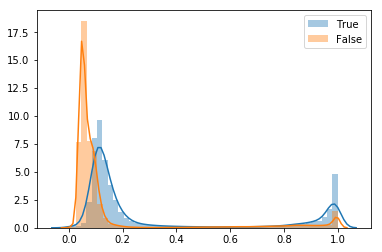

In [89]:
sns.distplot(all_predicted_events[all_true_events > 0.5], label="True")
sns.distplot(all_predicted_events[all_true_events < 0.5], label="False")
plt.legend()

In [119]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

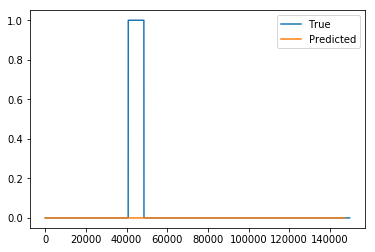

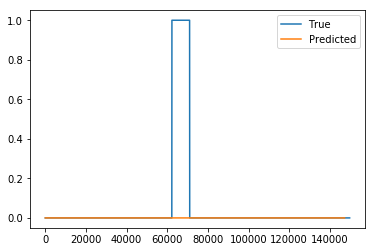

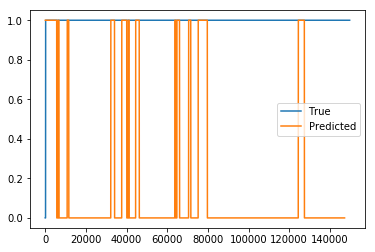

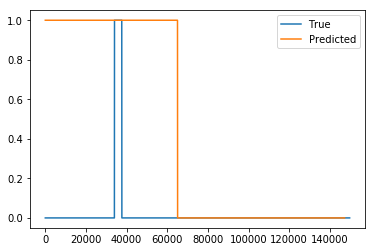

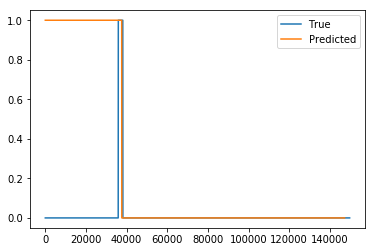

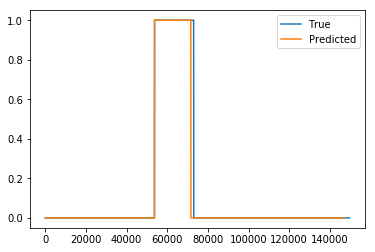

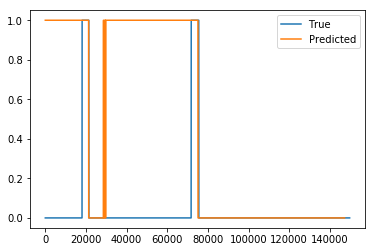

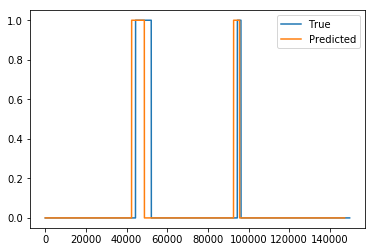

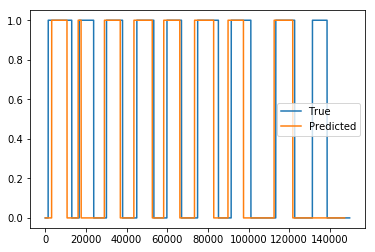

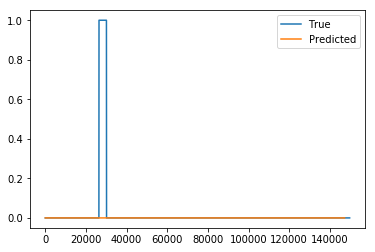

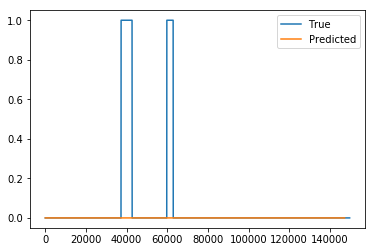

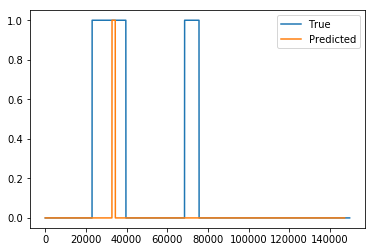

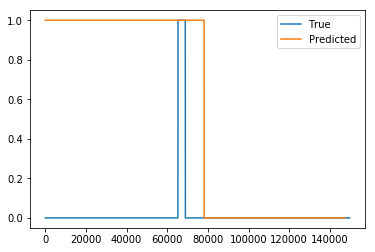

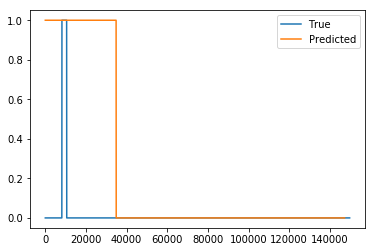

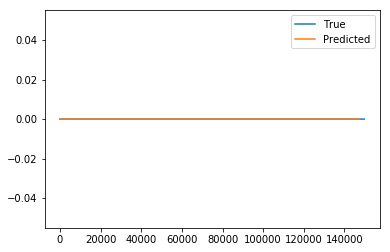

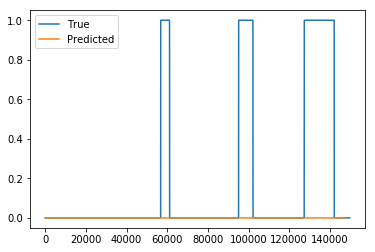

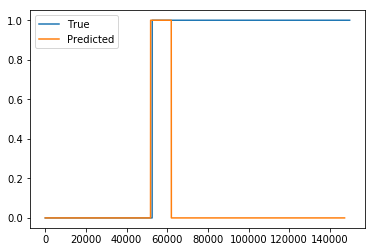

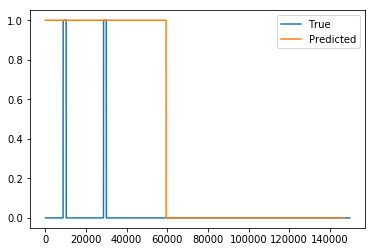

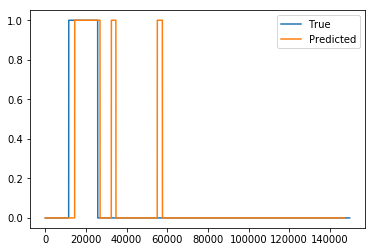

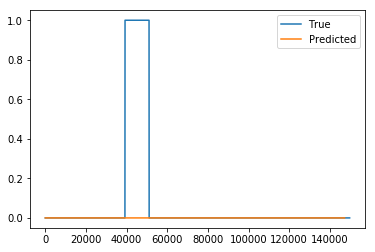

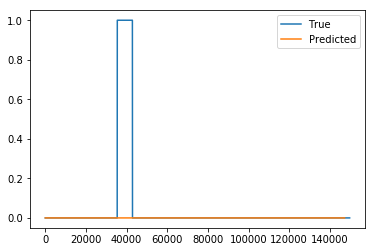

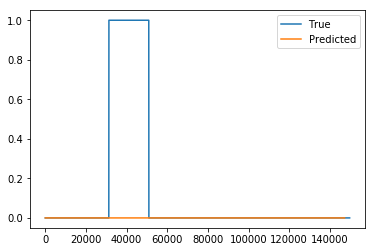

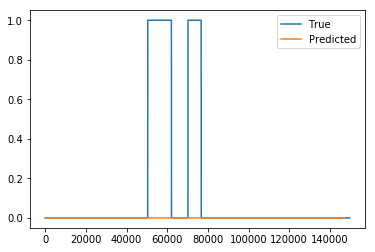

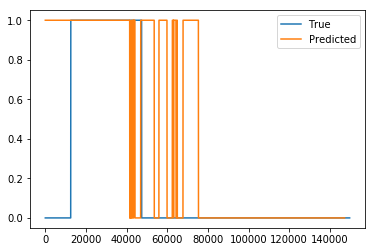

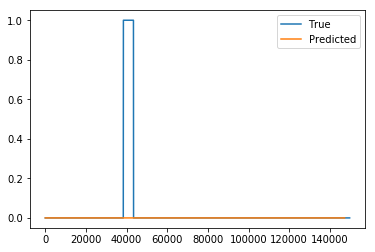

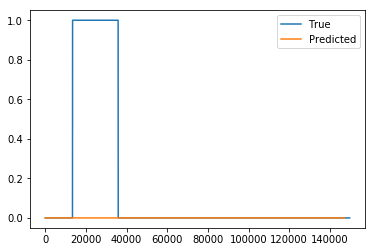

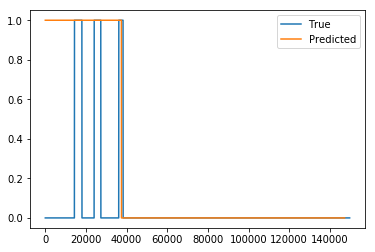

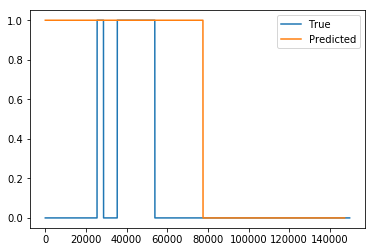

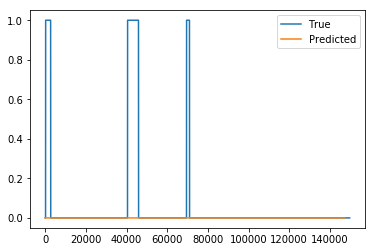

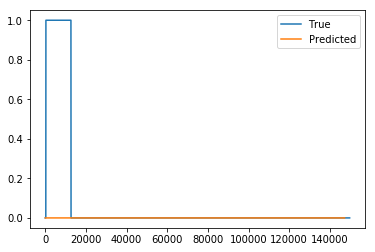

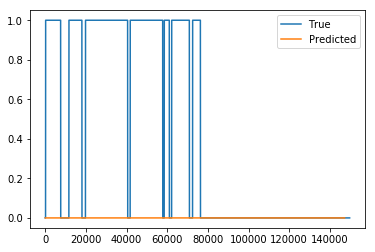

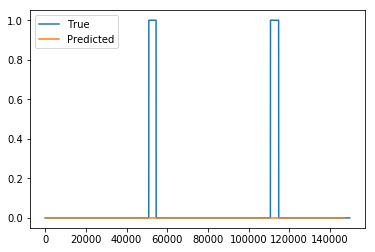

In [133]:
for series in range(32):
    true_events_line = all_true_events[:, series, :, :].reshape(-1)
    predicted_events_line = all_predicted_events[:, series, :, :].reshape(-1)
    predicted_events_line = (moving_average(predicted_events_line, n=min_seizure_duration) > 0.3).astype(int)
    plt.plot(true_events_line, label="True")
    plt.plot(predicted_events_line, label="Predicted")
    plt.legend()
    plt.show()

TODO

In time

# Flatten the curve

In [112]:
min_seizure_duration = CHUNK_FREQUENCY * 10

In [113]:
min_seizure_gap = CHUNK_FREQUENCY * 3

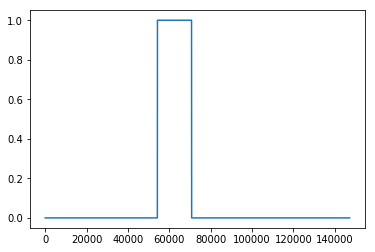

In [131]:
plt.plot()

# Compare focal loss params

In [602]:
def np_focal_loss(y_true, y_pred, gamma, alpha):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    p1 = y_pred[(y_true > 0.5)]
    p0 = y_pred[(y_true < 0.5)]
    p1_mean = - np.sum(alpha * ((1 - p1) ** gamma) * np.log(p1))
    p0_mean = - np.sum((1 - alpha) * (p0 ** gamma) * np.log(1 - p0))
    return (p1_mean + p0_mean) / y_true.shape[0]

In [603]:
shape = 1000
y_true = (np.random.rand(shape) < 0.3).astype(float)
y_pred_1 = 0.5 * np.ones(y_true.shape)
y_pred_2 = 0.1 * np.ones(y_true.shape) # Should be greater than 1
y_pred_3 = 0.49 * np.ones(y_true.shape) + (y_true > 0.5) * (0.9 - 0.49) # Should be less than 1
y_pred_4 = 0.99 * np.ones(y_true.shape) # Should be greater than 1

In [604]:
gamma = 1
alpha = 0.5

In [605]:
np_focal_loss(y_true, y_pred_1, gamma=gamma, alpha=alpha)

0.17328679513998635

In [606]:
np_focal_loss(y_true, y_pred_2, gamma=gamma, alpha=alpha)

0.3279382440610576

In [607]:
np_focal_loss(y_true, y_pred_3, gamma=gamma, alpha=alpha)

0.11498288055263572

In [608]:
np_focal_loss(y_true, y_pred_4, gamma=gamma, alpha=alpha)

1.5660729280736512

# Seq2seq

In [ ]:
feature_extractor = eeg_input

for cnn_filters in CNN_FILTERS:
    feature_extractor = keras.layers.Conv1D(cnn_filters, kernel_size=3, padding="same", activation="relu")(feature_extractor)
    feature_extractor = keras.layers.Conv1D(cnn_filters, kernel_size=3, padding="same", activation="relu")(feature_extractor)
    feature_extractor = keras.layers.MaxPool1D(pool_size=2, padding="same")(feature_extractor)

In [ ]:
encoder_outputs, encoder_h_state, encoder_c_state = keras.layers.LSTM(RNN_SIZE, stateful=True, return_state=True)(feature_extractor)

events_input = keras.layers.Input(batch_shape=(BATCH_SIZE, CHUNK_TIME, 1), name="events")

decoder_outputs, _, _ = keras.layers.LSTM(RNN_SIZE, return_sequences=True, return_state=True)(
    events_input, 
    initial_state=[encoder_h_state, encoder_c_state]
)
decoder_outputs = keras.layers.Dense(1, activation='sigmoid')(decoder_outputs)

model = keras.models.Model(inputs=[eeg_input, events_input], outputs=[decoder_outputs])